In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.decomposition import PCA

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel
from canon.seq.seqreader import SeqReader
from canon.pattern.labeler import SeqLabeler

def read_seq(seq, key="orsnr___"):
    seqfile = os.path.join("seq", seq+".SEQ")
    reader = SeqReader(seqfile)    
    Z = reader.get_Zmap(key)[0]
    return Z[::-1, :]

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]
    
def xy_to_idx(x, y, img_shape):
    return y * img_shape[1] + x

def idx_to_xy(idx, img_shape, flip_vertical=True):
    x = int(idx / img_shape[1])
    y = idx % img_shape[1]
    if flip_vertical:
        x = img_shape[0] - x - 1
    return y, x

Using TensorFlow backend.


## Feature Extraction

In [7]:
# feature_file = "hit_100_20_3_1_150_150"
# img_shape = (150, 150)
# aspect_ratio = 1
# seqs = ["hit_100_20_3_1_150_150"]

# feature_file = "au29_area2_50_150_128"
# img_shape = (50, 150)
# aspect_ratio = 1.5

# feature_file = "BTO_25C_wb3_60_100"
# img_shape = (60, 100)
# aspect_ratio = 1
# seqs = ["BTO_25C_wb3_"]

feature_file = "BTO_01_m_zoom"
img_shape = (84, 68)
aspect_ratio = 1
seqs = ["BTO_01_m_zoom_"]

feature_file = "SN3_a"
img_shape = (50, 60)
aspect_ratio = 1

# feature_file="C5_30x30"
# img_shape = (30, 30)
# aspect_ratio = 1
# seqs = ["C5_30x30"]

ae_models = []
features = []

with h5py.File(os.path.join("features", feature_file +'.hdf5'), 'r') as h5f:
    for k in h5f.keys():
        print(k)
        data = np.array(h5f.get(k))
        print(data.shape)
        features.append(fill_features(data, img_shape))
        ae_models.append(k)
print("Read {} datasets for models {}".format(len(features), ae_models))

ae_conv_4_256_best
(2999, 257)
Filling 2999 features to 3000 data points
Read 1 datasets for models ['ae_conv_4_256_best']


## Direct Coloring
Directly color each point using the first 3 principal components, without clustering.

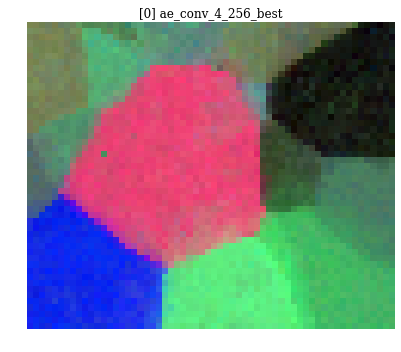

In [8]:
def draw_direct_color(features, ax):
    pca = PCA(n_components=3)
    X = pca.fit_transform(features)
    pca_range = [X.min(axis=0), X.max(axis=0)]
    X = (X - pca_range[0]) / (pca_range[1] - pca_range[0])
    Z = np.zeros((img_shape[0], img_shape[1], 3))
    Z[:, :, 0] = X[:, 0].reshape(img_shape)
    Z[:, :, 1] = X[:, 1].reshape(img_shape)
    Z[:, :, 2] = X[:, 2].reshape(img_shape)
    ax.imshow(Z[::-1, :, :], aspect=aspect_ratio)

for i, m in enumerate(ae_models):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
    f = features[i]
    draw_direct_color(f, ax)
    ax.set_title("[%d] %s" % (i, m), fontsize=12)
    ax.axis('off')
    plt.tight_layout()

Pick one data set for following calculation

In [5]:
dataset = 0
ae_model = ae_models[dataset]
samples = features[dataset]

N = samples.shape[0]
M = samples.shape[1]

mPCA = None

model = KMeansModel()
if mPCA is not None and mPCA < samples.shape[1]:
    pca = PCA(n_components=mPCA)
    preprocessors = [pca]
else:
    preprocessors=[]

## Clustering
The normal clustering + labeling

Silhouette Score = 0.08437957621492415, Calinski-Harabaz Score = 254.21410510661326


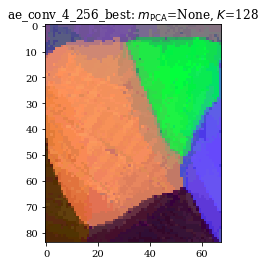

In [9]:
K = 128

if N > 6400:
    print("To many feature vectors, pick 6400 samples to train clustering")
    training_set = samples[np.random.choice(np.arange(N), 6400)]
else:
    training_set = samples
model.train(training_set, n_clusters=K, preprocessors=preprocessors)

scores = np.array(model.score(samples))

silhouette = model.compute_silhouette_score(samples)
calinski = model.compute_calinski_harabaz_score(samples)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

fig, ax = plt.subplots(ncols=1, nrows=1)

Z = model.color_by_pca(scores.reshape(img_shape), scaling='centroids')
ax.imshow(Z[::-1, :, :], aspect=aspect_ratio)
ax.set_title(r'%s: $m_{\rm PCA}$=%s, $K$=%s' % (ae_model, mPCA, K));

## Indexing Labeler

Requires SEQ file(s)

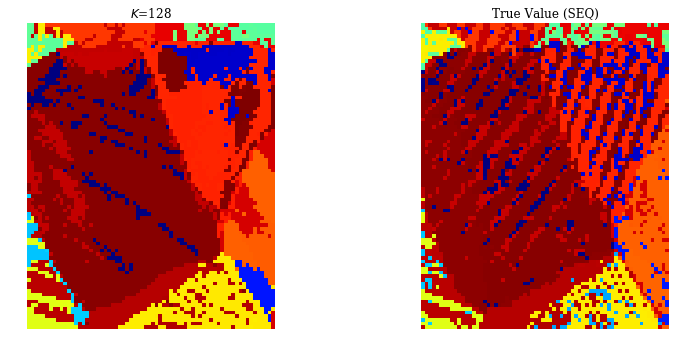

In [10]:
Z = read_seq(seqs[0])
vmax, vmin = Z.max(), Z.min()
seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))

Z = model.score_by_seqs(samples, seqfiles)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ax[0].imshow(Z[::-1, :], cmap='jet', aspect=1)
ax[0].axis('off')
ax[0].set_title(r'$K$=%d' % K, fontsize=12)
ax[1].imshow(Z_seq[::-1, :], cmap='jet', aspect=1)
ax[1].axis('off')
ax[1].set_title(r'True Value (SEQ)', fontsize=12)
plt.tight_layout()

# Silhouette Score & Calinski-Harabaz Score
Use Silhouette Score & Calinski-Harabaz Score to estimate number of "coarse" clusters.
Good for grain boundaries and phase boundaries.

In [ ]:
from joblib import Parallel, delayed

Ks = np.arange(2, 20, 1)
SCs=[]

def sc_scores(K):
    print("K=", K)
    model = KMeansModel()
    pca = PCA(n_components=32)
    if N > 6400:
        print("To many feature vectors, pick 6400 samples to train clustering")
        training_set = samples[np.random.choice(np.arange(N), 6400)]
    else:
        training_set = samples
    model.train(training_set, n_clusters=K, preprocessors=preprocessors)
    silhouette = model.compute_silhouette_score(samples)
    calinski = model.compute_calinski_harabaz_score(samples)
    print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))
    return silhouette, calinski

with Parallel(n_jobs=-1, verbose=1) as parallel:
    SCs = parallel(delayed(sc_scores)(k) for k in Ks)
    SCs = np.array(SCs)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(Ks, SCs[:, 0], 'o--k', markerfacecolor='w', markersize=5)
ax[0].set_xlabel(r'Number of Clusters', fontsize=12)
ax[0].set_ylabel(r'Silhouette Score', fontsize=12)

ax[1].plot(Ks, SCs[:, 1], 'o--k', markerfacecolor='w', markersize=5)
ax[1].set_xlabel(r'Number of Clusters', fontsize=12)
ax[1].set_ylabel(r'Calinski-Harabaz Score', fontsize=12)

plt.tight_layout()